# EOSGenerators module guide

## RMF EOS 

First import all of the package that will be used here.

In [1]:
import EOSgenerators.crust_EOS as crust
import EOSgenerators.RMF_EOS as RMF
import EOSgenerators.Polytrope_EOS as Polytrope
import EOSgenerators.Strangeon_EOS as Strangeon
import TOVsolver.main as main
import matplotlib.pyplot as plt
import numpy as np
import math
from TOVsolver.unit import g_cm_3, dyn_cm_2, km, Msun, MeV, fm
from TOVsolver.maxium_central_density import maxium_central_density

###  (a) Load crust EOS and prepare interface EOS

Define constants, and load the crust EOS into this notebook, since when we solve the equation of state to TOV equation, we need full scope of the equation of state. Here, crust eos file is 'Tolos_crust_out.txt', while we need to times g_cm_3 for energy density and dyn_cm_2 for pressure, that will be easier for treatment, no need worry about G and c.

Then just connect the crust part with the interface part(the part between core equation of state and crust) by a PolyInterpolate function

In [2]:
Tolos_crust_out = np.loadtxt("Test_Case/Tolos_crust_out.txt")
eps_crust_T_out = Tolos_crust_out[:, 3] * g_cm_3
pres_crust_T_out = Tolos_crust_out[:, 4] * dyn_cm_2
eps_com, pres_com = crust.PolyInterpolate(eps_crust_T_out, pres_crust_T_out)

## Example of RMF

### (b) Defining the paramters

Defining the free prameters that we need to compute the equation of state, you could check our intro part of documentation or just check the original paper of us about details. [Huang et al,2023](https://arxiv.org/abs/2303.17518)

After defined the equation of state parameters, we could call the 'compute_EOS' function from RMF, to compute full core equation of state.

In [3]:
m_sig = 495.0 / 197.33
m_w = 3.96544
m_rho = 3.86662

g_sigma = math.sqrt(107.5751)
g_omega = math.sqrt(182.3949)
g_rho = math.sqrt(206.4260)

kappa = 3.09114168 / 197.33
lambda_0 = -0.00168015405
zeta = 0.024
Lambda_w = 0.045
theta = np.array(
    [m_sig, m_w, m_rho, g_sigma, g_omega, g_rho, kappa, lambda_0, zeta, Lambda_w]
)
eps, pres = RMF.compute_EOS(eps_com, pres_com, theta)

### (c) Connecting Core and crust EOS

These two line can easily connect the Equation of state we computed for core part by setting the parameters and the crust equation of state, to a full equation of state that prepared for next step output


In [4]:
eps_total = np.array([*eps_com, *eps])
pres_total = np.array([*pres_com, *pres])

Here below is one of the possiblity, use our defined function, 'OutputMR' to compute out what the mass radius curve corresponding to this equation of state.

In [5]:
MR = main.OutputMR("", eps_total, pres_total).T

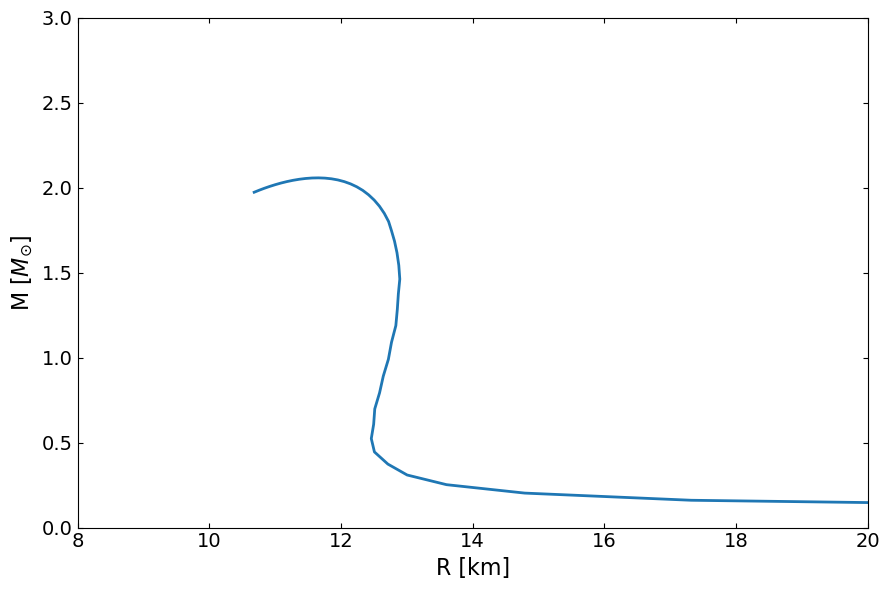

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.plot(MR[1] / km, MR[0] / Msun, lw=2)
ax.set_ylabel(r"M [$M_{\odot}$]", fontsize=16)
ax.set_xlabel("R [km]", fontsize=16)
ax.set_xlim(8.0, 20.0)
ax.set_ylim(0, 3)
ax.tick_params(top=1, right=1, which="both", direction="in", labelsize=14)
ax.tick_params(top=1, right=1, which="both", direction="in", labelsize=14)
fig.tight_layout()
plt.show()

### (d) Chemical potential ($\mu$) and proton fraction ($X_p$)

Both `EOSgenerators.RMF_EOS` and `EOSgenerators.fastRMF_EoS` provide functionality to return an equation of state (EoS) array along with the chemical potentials for neutrons, protons, electrons, muons, and the proton fraction. As shown in the previous section (a), the default output format includes separate lists for energy and pressure.

To obtain the compositional information of the $\beta$-equilibrium EoS, you can set the `return_tag` parameter to `True`. 

When `return_tag=True`:
- The function returns a 1D NumPy array containing various EoS components:
    - `EoS[0]`: Number density in fm⁻³
    - `EoS[1]`: Energy density in natural units
    - `EoS[2]`: Pressure in natural units
    - `EoS[3]`: Proton chemical potential in natural units
    - `EoS[4]`: Neutron chemical potential in natural units
    - `EoS[5]`: Electron chemical potential in natural units
    - `EoS[6]`: Muon chemical potential in natural units
    - `EoS[7]`: Proton fraction (dimensionless)

Example:
```python
EoS_composition = RMF.compute_EOS(eps_com, pres_com, theta, return_tag=True)
```

In [7]:
# Compute the EoS composition in beta equilibrium
EoS_composition = RMF.compute_EOS(eps_com, pres_com, theta, return_tag=True)

# Number density in fm⁻³
rho = EoS_composition[0]

# Convert energy density and pressure from natural units to MeV.fm⁻³
e = EoS_composition[1] / (MeV * fm**(-3))    # Energy density in MeV.fm⁻³
p = EoS_composition[2] / (MeV * fm**(-3))    # Pressure in MeV.fm⁻³

# Convert chemical potentials to MeV
mu_p = EoS_composition[3] / MeV  # Proton chemical potential in MeV
mu_n = EoS_composition[4] / MeV  # Neutron chemical potential in MeV
mu_e = EoS_composition[5] / MeV  # Electron chemical potential in MeV
mu_mu = EoS_composition[6] / MeV # Muon chemical potential in MeV

# Proton fraction (dimensionless)
xp = EoS_composition[7]

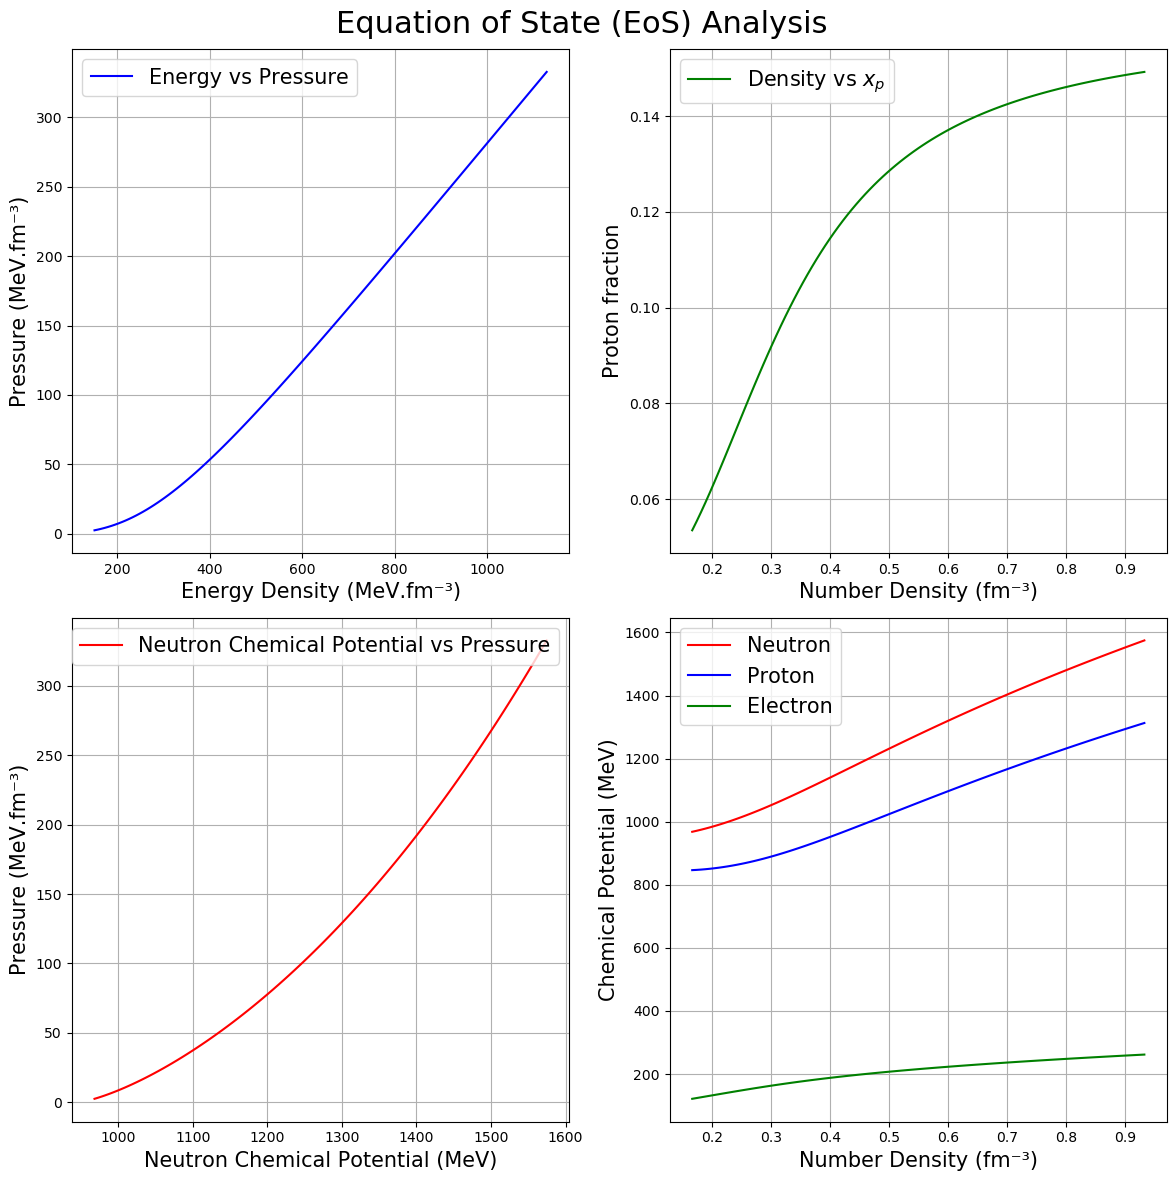

In [8]:
# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("Equation of State (EoS) Analysis",fontsize=22)

# Panel a) e vs p
axs[0, 0].plot(e, p, color='blue', label='Energy vs Pressure')
axs[0, 0].set_xlabel("Energy Density (MeV.fm⁻³)" ,fontsize=15)
axs[0, 0].set_ylabel("Pressure (MeV.fm⁻³)",fontsize=15)
axs[0, 0].legend(fontsize=15)
axs[0, 0].grid(True)

# Panel b) rho vs p
axs[0, 1].plot(rho, xp, color='green', label='Density vs $x_p$')
axs[0, 1].set_xlabel("Number Density (fm⁻³)",fontsize=15)
axs[0, 1].set_ylabel("Proton fraction",fontsize=15)
axs[0, 1].legend(fontsize=15)
axs[0, 1].grid(True)

# Panel c) mu_n vs p
axs[1, 0].plot(mu_n, p, color='red', label='Neutron Chemical Potential vs Pressure')
axs[1, 0].set_xlabel("Neutron Chemical Potential (MeV)",fontsize=15)
axs[1, 0].set_ylabel("Pressure (MeV.fm⁻³)",fontsize=15)
axs[1, 0].legend(fontsize=15)
axs[1, 0].grid(True)

# Panel d) rho vs mu_n, mu_p, and mu_e
axs[1, 1].plot(rho, mu_n, color='red', label='Neutron')
axs[1, 1].plot(rho, mu_p, color='blue', label='Proton')
axs[1, 1].plot(rho, mu_e, color='green', label='Electron')
axs[1, 1].set_xlabel("Number Density (fm⁻³)",fontsize=15)
axs[1, 1].set_ylabel("Chemical Potential (MeV)",fontsize=15)
axs[1, 1].legend(fontsize=15)
axs[1, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## A Microscopic Approach with Density-Dependent Coupling in Relativistic Mean field Models

This notebook explores a microscopic approach to modeling hadrons based on relativistic mean-field theory, where hadrons interact through density-dependent couplings with mesons (DDH). This approach, unlike constant coupling methods, incorporates quantal fluctuations of baryon fields even in the ground state, as demonstrated by Lenske and Fuchs (1995, *Physical Review B*, 345, 355).

The DDH parameterization has been particularly effective in describing both the properties of nuclear matter and finite nuclei. Notably, Typel and Wolter (1999, *Nuclear Physics A*, 656, 331) developed a DDH parameterization that captures essential nuclear characteristics accurately.

### Types of Density-Dependent Functional Dependence for Couplings

The literature explores various functional dependencies for isoscalar and isovector couplings in the DDH model. Three well-known types are:

1. **Typel-Wolter Type (1999)**: The original functional form introduced by Typel and Wolter (1999) in *Nuclear Physics A*.
2. **DDB (Density-Dependent Bayesian) Type**: Introduced in *Astrophysical Journal* (930, 2022, 17) and detailed in e-Print: 2201.12552, this parameterization leverages Bayesian approaches for improved model precision.
3. **Char23 Type**: A more recent functional form, as seen in arXiv:2307.12364.
4. Possibility of implementing Different Density-Dependent Functionals: Our density-dependent relativistic mean-field (RMF) model supports all three types of functional dependencies, allowing users to select or define custom functional forms based on specific research needs.

In [9]:
import EOSgenerators.RMF_DDH as DDH
from TOVsolver.constant import oneoverfm_MeV,G,c

## (a) Compute DDH EOS

The function `DDH.Function` calculates the coupling constants \( g_{\sigma}(\rho) \), \( g_{\omega}(\rho) \), and \( g_{\rho}(\rho) \) based on different models for density dependence. It returns symbolic expressions for each coupling and their derivatives with respect to density, allowing flexible evaluations across a range of densities.

### Key Parameters

- **type**: Specifies the density-dependence model. Options include:
    - `"Typel99"` (default): Implements the DD-MEX model from *Typel99* (Reference: 2008.04491).
    - `"Malik22"`: Uses the DDBm model parameters as detailed in *Malik22* (Reference: 2201.12552).
    - `"Char23"`: Model I from *Char23* (Reference: 2307.12364).
    - `"UserDefined"`: Allows custom LaTeX expressions for each coupling.

- **couplings**: Specifies the coupling constants for the selected model.
    - `"Default"`: Uses preset values for the selected model.
    - Custom List: Users can input specific values if `"Default"` is not selected.

### Function Output

The `DDH.Function` function returns a tuple containing symbolic expressions for each coupling and its derivative:

1. **\( g_{\sigma}(\rho) \)**: Sigma meson coupling
2. **\( g_{\omega}(\rho) \)**: Omega meson coupling
3. **\( g_{\rho}(\rho) \)**: Rho meson coupling
4. **\( \frac{d g_{\sigma}}{d \rho} \)**: Derivative of sigma coupling with respect to density
5. **\( \frac{d g_{\omega}}{d \rho} \)**: Derivative of omega coupling with respect to density
6. **\( \frac{d g_{\rho}}{d \rho} \)**: Derivative of rho coupling with respect to density

### Example Usage

The following example shows how to initialize the function with a specified model type and retrieve the resulting coupling expressions:

```python
# Example usage
gs, gw, gr, dgs, dgw, dgr = DDH.Function(type='Typel99', couplings="Default")
```

This call returns the symbolic expressions for each meson coupling and their derivatives based on the DD-MEX model (Typel99) with default parameters. Adjust `type` and `couplings` as needed for different models or custom values.

In [11]:
## DDMEX model (Huang et al, arxiv: 2008.04491)
m_sig = (547.3327)/oneoverfm_MeV
m_w   = (783)/oneoverfm_MeV
m_rho = (763)/oneoverfm_MeV
rho0  = 0.153

gsf, gwf, grf, dgsf, dgwf, dgrf = DDH.Function(type='Typel99')
theta     = np.array([m_sig, m_w, m_rho, gsf, gwf, grf, dgsf, dgwf, dgrf, rho0])
EoS_DDMEX = DDH.compute_eos(eps_com, pres_com, theta)

## DDBm (Malik et al, arxiv: 2201.12552)
m_sig = (550)/oneoverfm_MeV

gsf, gwf, grf, dgsf, dgwf, dgrf = DDH.Function(type='Malik22')
theta     = np.array([m_sig, m_w, m_rho, gsf, gwf, grf, dgsf, dgwf, dgrf, rho0])
EoS_DDBm = DDH.compute_eos(eps_com, pres_com, theta)


## Model I  ( Char et al, arxiv:2307.12364)
m_sig = (550.0)/oneoverfm_MeV
m_w   = (782.6)/oneoverfm_MeV
m_rho = (769)/oneoverfm_MeV

gsf, gwf, grf, dgsf, dgwf, dgrf = DDH.Function(type='Char23')
theta     = np.array([m_sig, m_w, m_rho, gsf, gwf, grf, dgsf, dgwf, dgrf, rho0])
EoS_Char23  = DDH.compute_eos(eps_com, pres_com, theta)

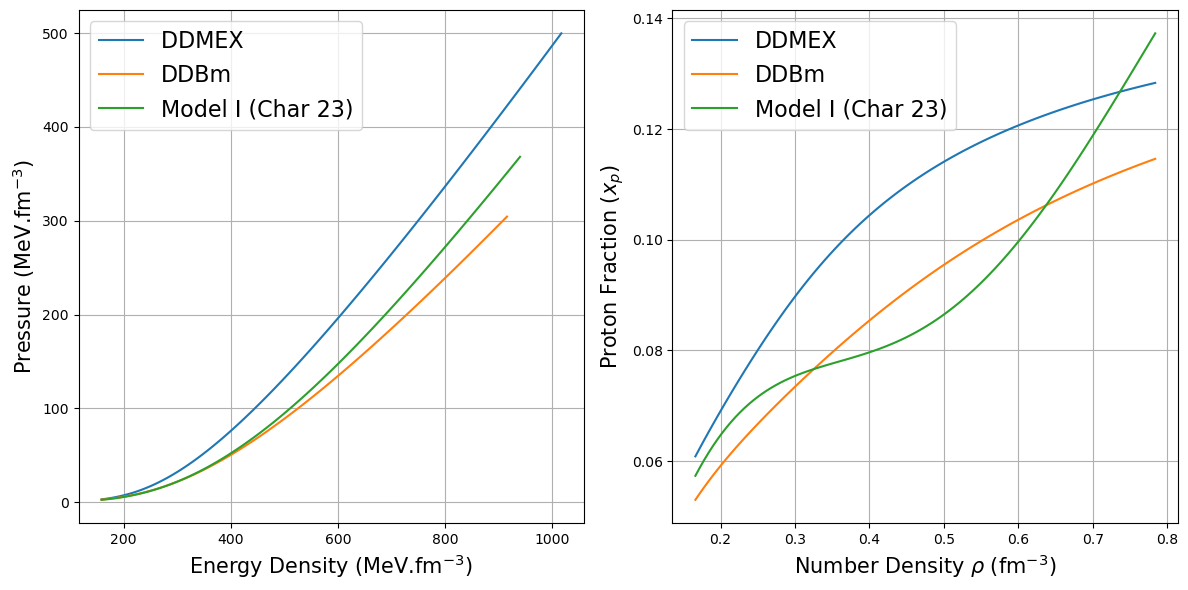

In [12]:
rho_DDMEX = EoS_DDMEX[0] # in fm-3
e_DDMEX   = EoS_DDMEX[1]/(MeV*fm**(-3)) ## in MeV.fm-3
p_DDMEX   = EoS_DDMEX[2]/(MeV*fm**(-3)) ## in MeV.fm-3
xp_DDMEX  = EoS_DDMEX[3]  ## dimentionless

rho_DDBm = EoS_DDBm[0] # in fm-3
e_DDBm   = EoS_DDBm[1]/(MeV*fm**(-3)) ## in MeV.fm-3
p_DDBm   = EoS_DDBm[2]/(MeV*fm**(-3)) ## in MeV.fm-3
xp_DDBm  = EoS_DDBm[3]  ## dimentionless

rho_char23 = EoS_Char23[0] # in fm-3
e_char23   = EoS_Char23[1]/(MeV*fm**(-3)) ## in MeV.fm-3
p_char23   = EoS_Char23[2]/(MeV*fm**(-3)) ## in MeV.fm-3
xp_char23  = EoS_Char23[3]  ## dimentionless
     
    
    
# Create a two-panel plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# First panel: Energy density and Pressure vs Number density
ax1.plot(e_DDMEX, p_DDMEX, label="DDMEX ")
ax1.plot(e_DDBm, p_DDBm, label="DDBm")
ax1.plot(e_char23, p_char23, label="Model I (Char 23)")
ax1.set_xlabel(r"Energy Density (MeV.fm$^{-3}$)", fontsize=15)
ax1.set_ylabel(r"Pressure (MeV.fm$^{-3}$)", fontsize=15)
ax1.legend(fontsize=16)
ax1.grid(True)

# Second panel: Proton fraction vs Number density
ax2.plot(rho_DDMEX, xp_DDMEX, label="DDMEX")
ax2.plot(rho_DDBm, xp_DDBm, label="DDBm")
ax2.plot(rho_char23, xp_char23, label="Model I (Char 23)")
ax2.set_xlabel(r"Number Density $\rho$ (fm$^{-3}$)", fontsize=15)
ax2.set_ylabel(r"Proton Fraction ($x_p$)", fontsize=15)
ax2.legend(fontsize=16)
ax2.grid(True)

plt.tight_layout()
plt.show()                 

## (b) Compute the TOV

In [13]:
eps_DDMEX  = np.array([*eps_com, *EoS_DDMEX[1]])
pres_DDMEX = np.array([*pres_com, *EoS_DDMEX[2]])
MR_DDMEX   = main.OutputMR("", eps_DDMEX, pres_DDMEX).T

eps_DDBm  = np.array([*eps_com, *EoS_DDBm[1]])
pres_DDBm = np.array([*pres_com, *EoS_DDBm[2]])
MR_DDBm   = main.OutputMR("", eps_DDBm, pres_DDBm).T

eps_char23  = np.array([*eps_com, *EoS_Char23[1]])
pres_char23 = np.array([*pres_com, *EoS_Char23[2]])
MR_char23   = main.OutputMR("", eps_char23, pres_char23).T

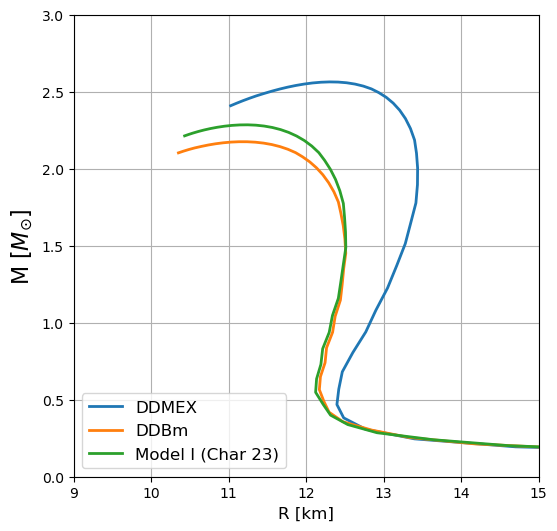

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.plot(MR_DDMEX[1] / km, MR_DDMEX[0] / Msun, lw=2, label="DDMEX")
ax.plot(MR_DDBm[1] / km, MR_DDBm[0] / Msun, lw=2,  label="DDBm")
ax.plot(MR_char23[1]  / km, MR_char23[0]  / Msun, lw=2, label="Model I (Char 23)")
ax.set_ylabel(r"M [$M_{\odot}$]", fontsize=16)
ax.set_xlabel("R [km]", fontsize=12)
ax.set_xlim(9.0, 15)
ax.set_ylim(0, 3)
ax.grid(True)
plt.legend(loc="lower left", fontsize=12)
plt.show()

## (c) DDH exciting feature on User defined functions

Example: re-compute Model I ( char23 ) and with User defined feature 

In [16]:
##### Model I  ( Char et al, arxiv:2307.12364)
m_sig = (550.0)/oneoverfm_MeV
m_w   = (782.6)/oneoverfm_MeV
m_rho = (769)/oneoverfm_MeV

gsf, gwf, grf, dgsf, dgwf, dgrf = DDH.Function(type='Char23')
theta     = np.array([m_sig, m_w, m_rho, gsf, gwf, grf, dgsf, dgwf, dgrf, rho0])
EoS_Char  = DDH.compute_eos(eps_com, pres_com, theta)

e_char = EoS_Char[1]/MeV
p_char = EoS_Char[2]/MeV

In [17]:
##### User Defined #########
as_, av, ar, bs, bv, br, cs, cv, cr, ds, dv, dr, rho0 = [8.225494 , 10.426752, 0.64584657,
                                                         2.7079569, 1.6468675, 5.2033131 ,
                                                         2.4776689, 6.8349408, 0.4262597 ,
                                                         3.8630221, 1.4458185, -0.1824181, 0.16194209]
n0 = 0.16

functions = [f"{as_} + ({bs} + {ds}*(x/{n0})**(3))*exp(-{cs}*x/{n0})",
             f"{av}  + ({bv} + {dv}*(x/{n0})**(3))*exp(-{cv}*x/{n0})",
             f"({ar} + ({br} + {dr}*(x/{n0})**(3))*exp(-{cr}*x/{n0}))*2"]

s,w,r, ds, dw, dr = DDH.Function(couplings=functions, type="UserDefined")
theta             = np.array([m_sig, m_w, m_rho, gsf, gwf, grf, dgsf, dgwf, dgrf, rho0])
EoS_user          = DDH.compute_eos(eps_com, pres_com, theta)

e_user = EoS_user[1]/MeV
p_user = EoS_user[2]/MeV

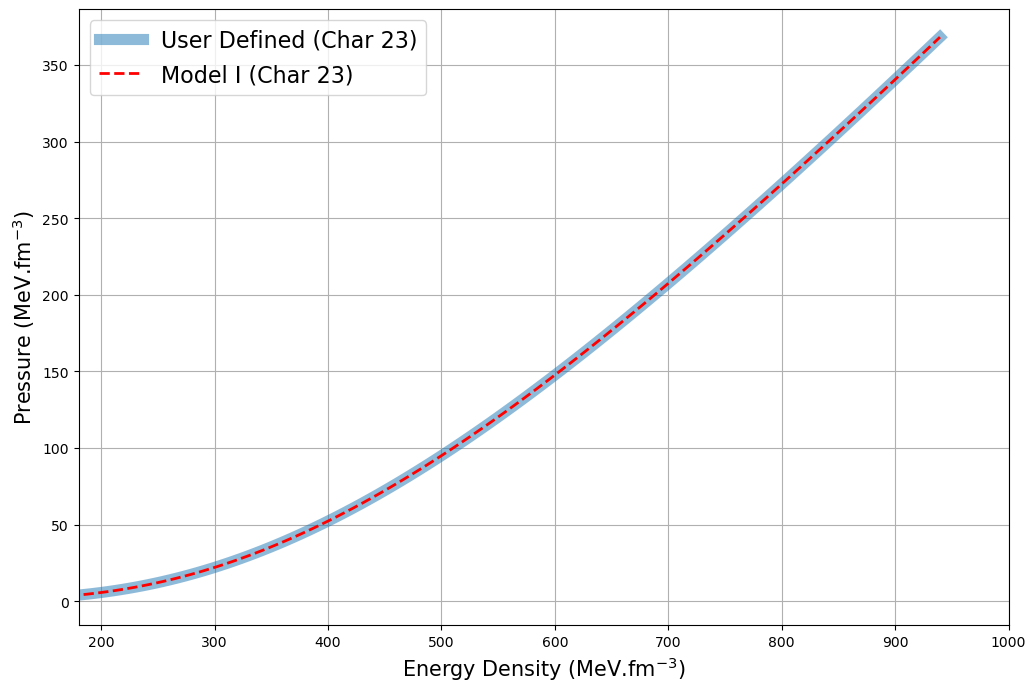

In [18]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

# First panel: Energy density and Pressure vs Number density
ax1.plot(e_user, p_user, label="User Defined (Char 23)", lw=8, alpha=0.5)
ax1.plot(e_char, p_char, label="Model I (Char 23)", lw=2, alpha=1, c="red", linestyle="--")
ax1.set_xlabel(r"Energy Density (MeV.fm$^{-3}$)", fontsize=15)
ax1.set_ylabel(r"Pressure (MeV.fm$^{-3}$)", fontsize=15)
ax1.set_xlim(180, 1000)
ax1.legend(fontsize=16)
ax1.grid(True)

## Illustrating the power of Numba accelerated EoS Generation

We shall now run the same code but with the Numba accelerated version, comparing the times for EoS Generation.

Keep in mind all previous definitions are still valid, all we need to change is a single line of code.


In [ ]:
import EOSgenerators.fastRMF_EoS as FastRMF
import time

Tolos_crust_out = np.loadtxt("Tolos_crust_out.txt")
eps_crust_T_out = Tolos_crust_out[:, 3] * g_cm_3
pres_crust_T_out = Tolos_crust_out[:, 4] * dyn_cm_2
eps_com, pres_com = crust.PolyInterpolate(eps_crust_T_out, pres_crust_T_out)

m_sig = 495.0 / 197.33
m_w = 3.96544
m_rho = 3.86662

g_sigma = math.sqrt(107.5751)
g_omega = math.sqrt(182.3949)
g_rho = math.sqrt(206.4260)

kappa = 3.09114168 / 197.33
lambda_0 = -0.00168015405
zeta = 0.024
Lambda_w = 0.045
theta = np.array(
    [m_sig, m_w, m_rho, g_sigma, g_omega, g_rho, kappa, lambda_0, zeta, Lambda_w]
)


### (a) Comparing the time it takes to generate the EoS

The reason why we test the time it takes to generate the EoS here is due to the fact that Numba is compiling the code, and as such the first run will take considerably longer to complete, but all other runs will be greatly faster.

Warning: Do not rerun this cell, as the compilation time will be gone.


In [8]:
### Normal RMF ####

first_run_time_normal = time.time()
eps_fast, pres_fast = RMF.compute_EOS(eps_com, pres_com, theta)
first_run_time_normal = time.time() - first_run_time_normal

time_for_20_runs_normal = time.time()
for _ in range(20):
    eps, pres = RMF.compute_EOS(eps_com, pres_com, theta)
time_for_20_runs_normal = time.time() - time_for_20_runs_normal


##### Fast RMF #####

first_run_time = time.time()
eps_fast, pres_fast = FastRMF.compute_EOS(eps_com, pres_com, theta)
first_run_time = time.time() - first_run_time

time_for_20_runs = time.time()
for _ in range(20):
    eps_fast, pres_fast = FastRMF.compute_EOS(eps_com, pres_com, theta)
time_for_20_runs = time.time() - time_for_20_runs


print(f"--------------------------------------------------------------------------------------")
print(f"|" + " "*84 + "|")
print(f"|" + " "*32 + "Time Comparion Table" + " "*32 + "|")
print(f"|" + " "*84 + "|")
print(f"|" + " "*17 + f"Time for first run  with RMF-Normal  = {first_run_time_normal*1000:6.0f} ms" + " "*19 + "|")
print(f"|" + " "*17 + f"Time for first run  with RMF-Fast    = {first_run_time*1000       :6.0f} ms" + " "*19 + "|")
print(f"|" + " "*84 + "|")
print(f"|" + " "*17 + f"Time for   20  runs with RMF-Normal  = {time_for_20_runs_normal*1000:6.0f} ms" + " "*19 + "|")
print(f"|" + " "*17 + f"Time for   20  runs with RMF-Fast    = {time_for_20_runs*1000       :6.0f} ms" + " "*19 + "|")
print(f"|" + " "*84 + "|")
print(f"|" + " "*17 + f"Time for  all  runs with RMF-Normal  = {(first_run_time_normal + time_for_20_runs_normal)*1000:6.0f} ms" + " "*19 + "|")
print(f"|" + " "*17 + f"Time for  all  runs with RMF-Fast    = {(first_run_time        + time_for_20_runs       )*1000:6.0f} ms (Has Compilation) " + "|")
print(f"|" + " "*84 + "|")
print(f"|" + " "*17 + f"Time for   1   run  with RMF-Normal  = {time_for_20_runs_normal*1000/20:6.0f} ms  " + " "*17 + "|")
print(f"|" + " "*17 + f"Time for   1   run  with RMF-Fast    = {time_for_20_runs       *1000/20:6.0f} ms" + " "*19 + "|")
print(f"|" + " "*84 + "|")
print(f"|" + " "*84 + "|")
print(f"|" + " "*30 + f"Total Speed Up = {time_for_20_runs_normal/time_for_20_runs:.2f} x" + " "*30 + "|" )
print(f"--------------------------------------------------------------------------------------")

--------------------------------------------------------------------------------------
|                                                                                    |
|                                Time Comparion Table                                |
|                                                                                    |
|                 Time for first run  with RMF-Normal  =    700 ms                   |
|                 Time for first run  with RMF-Fast    =   2525 ms                   |
|                                                                                    |
|                 Time for   20  runs with RMF-Normal  =  14176 ms                   |
|                 Time for   20  runs with RMF-Fast    =    194 ms                   |
|                                                                                    |
|                 Time for  all  runs with RMF-Normal  =  14875 ms                   |
|                 Time for  all  runs with 

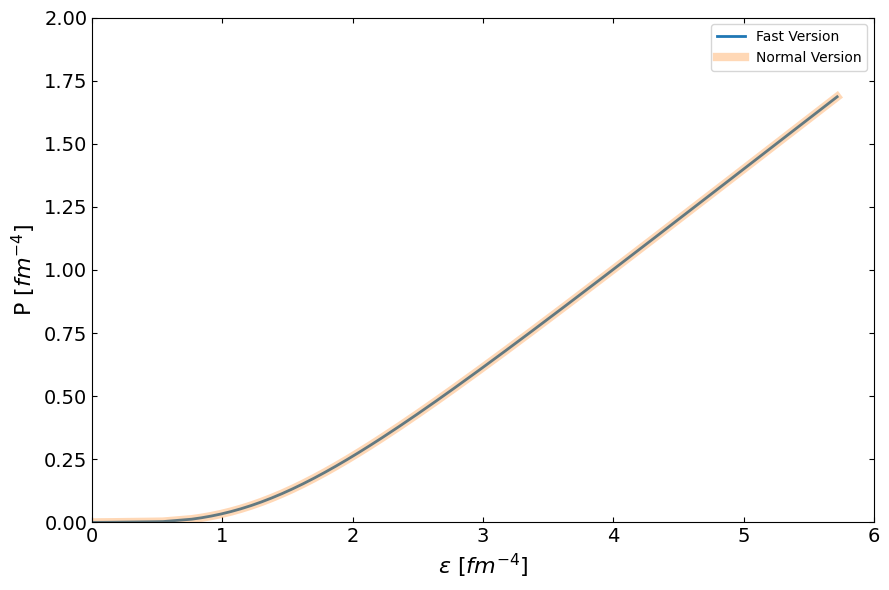

In [9]:
eps_total_fast = np.array([*eps_com, *eps_fast])
pres_total_fast = np.array([*pres_com, *pres_fast])

compare_fig1, ax = plt.subplots(1, 1, figsize=(9,6))

ax.plot(eps_total_fast, pres_total_fast, lw=2, label="Fast Version")
ax.plot(eps_total, pres_total, lw=6, label="Normal Version", alpha=0.3)
ax.set_ylabel(r"P $[fm^{-4}]$", fontsize=16)
ax.set_xlabel(r"$\epsilon$ $[fm^{-4}]$", fontsize=16)
ax.set_xlim(0, 6)
ax.set_ylim(0, 2)
ax.tick_params(top=1, right=1, which="both", direction="in", labelsize=14)
ax.tick_params(top=1, right=1, which="both", direction="in", labelsize=14)
plt.legend()
compare_fig1.tight_layout()
plt.show()

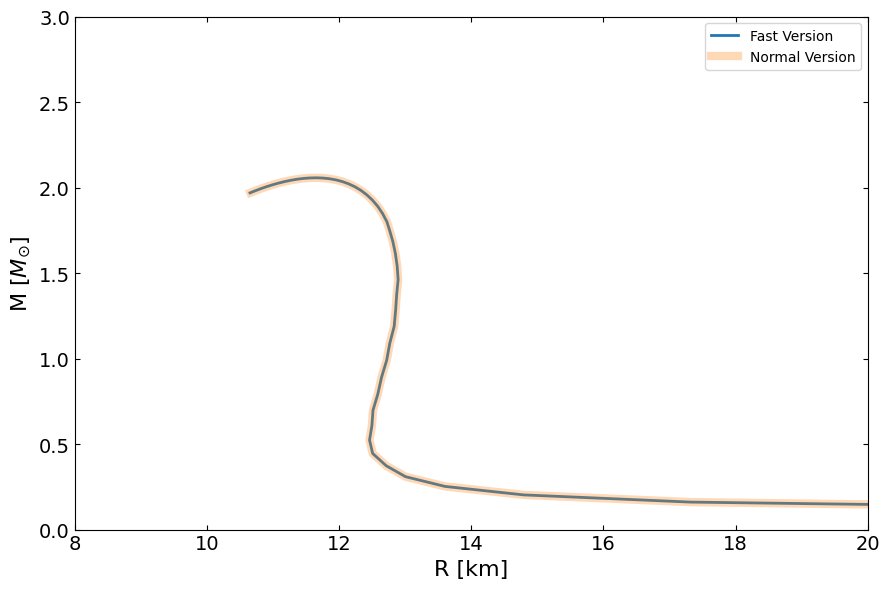

In [ ]:
MR_fast = main.OutputMR("", eps_total_fast, pres_total_fast).T

compare_fig2, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(MR_fast[0] / km, MR_fast[1] / Msun, lw=2, label="Fast Version")
ax.plot(MR[1] / km, MR[0] / Msun, lw=6, label="Normal Version", alpha=0.3)
ax.set_ylabel(r"M [$M_{\odot}$]", fontsize=16)
ax.set_xlabel("R [km]", fontsize=16)
ax.set_xlim(8.0, 20.0)
ax.set_ylim(0, 3)
ax.tick_params(top=1, right=1, which="both", direction="in", labelsize=14)
ax.tick_params(top=1, right=1, which="both", direction="in", labelsize=14)
plt.legend()
compare_fig2.tight_layout()
plt.show()

## Polytrope EOS 

First import all the package that will be used.

In [1]:
import numpy as np
import math
import TOVsolver.main as main
import matplotlib.pyplot as plt
from scipy.integrate import ode
import EOSgenerators.Polytrope_EOS as Polytrope
import EOSgenerators.Strangeon_EOS as Strangeon
import EOSgenerators.crust_EOS as crust
from TOVsolver.unit import  km, Msun, MeV,fm,g_cm_3,dyn_cm_2, G,c 

The polytropic equation of state (Polytrope) is the most commonly used EOS in astrophysics, its advantage is assumed to be capable to simulate all EOS shape with given parameters. Here, we provide one of the computation for polytrope.

### (a) Connecting outer crust with polytropic part

For polytrope, we first connecting it with crust as we did in RMF

In [2]:
Tolos_crust_out = np.loadtxt("Test_Case/Tolos_crust_out.txt")
eps_crust_T_out = Tolos_crust_out[:, 3] * g_cm_3
pres_crust_T_out = Tolos_crust_out[:, 4] * dyn_cm_2

We define a set of parameters, first three in theta are the parameters control the slope of each polytrope, and the last two are transition point from one segment to another. Details see the documentation about polytrope

In [3]:
gammas = np.array([1.03, 2.62, 1.38])
rho_ts = np.array([8.087e13, 1.8078e15]) * g_cm_3
theta = np.append(gammas, rho_ts)

eps_set = np.logspace(11.7, 15.6, 100, base=10) * g_cm_3
pres_out = Polytrope.compute_EOS(eps_set, theta, eps_crust_T_out[-1], pres_crust_T_out[-1])

eps_total = np.hstack((eps_crust_T_out, eps_set))
pres_total = np.hstack((pres_crust_T_out, pres_out))

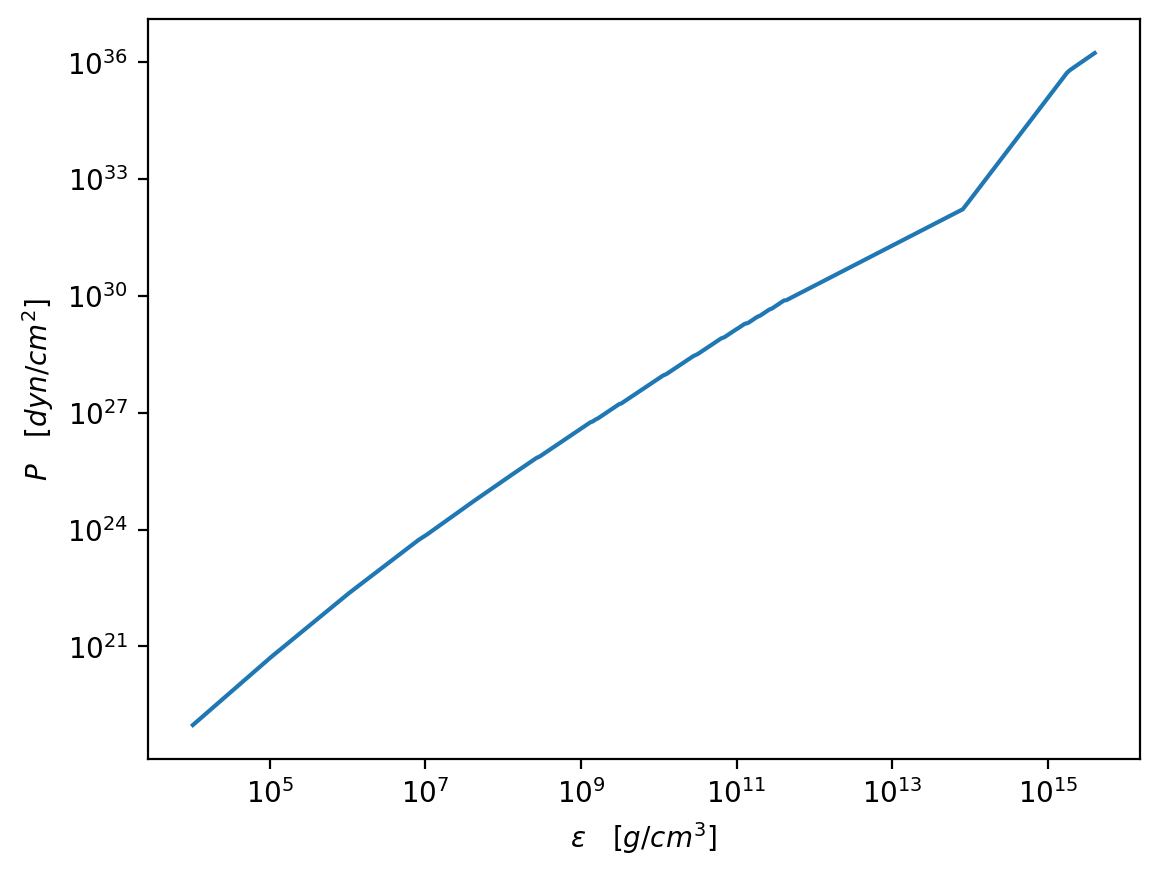

In [4]:
plt.figure(dpi=200)
plt.plot(eps_total / g_cm_3, pres_total / dyn_cm_2)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\epsilon\quad [g/cm^3]$")
plt.ylabel(r"$P\quad [dyn/cm^2]$")
plt.show()

### (b) Solve TOV with this EOS

Here below we use the strangeon matter EOS to compute the mass radius curve.

The following code calculates the mass and radius of the strange stars for the given EOS of the polytrope using our main.OutputMR

In [5]:
MR = main.OutputMR('',eps_total, pres_total)

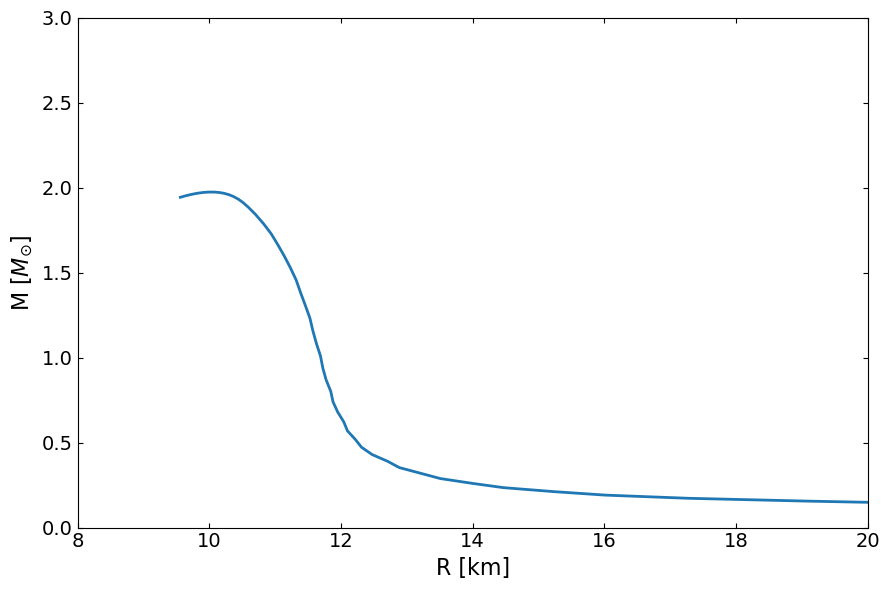

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.plot(MR[:,1]/km , MR[:,0]/Msun, lw=2)
# ax.scatter(R /km, M / Msun, c='r')
ax.set_ylabel(r"M [$M_{\odot}$]", fontsize=16)
ax.set_xlabel("R [km]", fontsize=16)
ax.set_xlim(8.0, 20.0)
ax.set_ylim(0, 3)
ax.tick_params(top=1, right=1, which="both", direction="in", labelsize=14)
ax.tick_params(top=1, right=1, which="both", direction="in", labelsize=14)
fig.tight_layout()
plt.show()

## Strangeon matter EOS 

First import all the package that will be used.

In [7]:
import numpy as np
import math
import TOVsolver.main as main
import matplotlib.pyplot as plt
from scipy.integrate import ode
from EOSgenerators import Strangeon_EOS

from TOVsolver.unit import  km, Msun, MeV,fm

The strangeon matter EOS describes the strongly interacting matter in the solid state, and the compact star can be a self-bound quark star composed of strangeon matter. Therefore, in the following we present the bare quark star EOS without a crust.

Note that the strangeon matter parameters we input are in the natural unit system. The quentity returned by the Strangeon_compute_EOS function is in the Geometric Unit System. Thus, here, the parameter epsilon and ns are in the units of $MeV/fm^{-3}$. So follow the unite conversion rule, if we are using this unit, we just time this unit to do compute

### (a) Defining the EOS parameters

Define the strangeon matter EOS that we will use to calculate the energy densities and pressures of the system.
The following is an example of how to define the theta and Nq.
For example, theta=[50, 0.24] means the example values for epsilon and ns:
epsilon in units of MeV, ns in units of $fm^-3$.
Nq is an integer, e.g. Nq=9, 12, 15, 18, 21, 24, 27

For the definition of parameter n, the minimum value is 3*ns/Nq, the maximum value is about 0.16*8*3/Nq.
Then we can generate,for example, 1000 points for the input of the srangeon matter EOS. Special note: If you are using this EOS, need a very fine grid for the EOS. From our test, 1000 points for this EOS is the minimum requirement

Once we define the EOS parameters already, we can use the Strangeon_compute_EOS function to calcute the energy_density and pressure.

In [8]:
Nq=18
epsilon=50
ns=0.24
theta = np.array([Nq, epsilon, ns])
n_min = 3 * theta[2] / theta[0]  
n_max = 0.16 * 8 * 3 / theta[0]   
n_values = np.linspace(n_min, n_max, 2000) 

energy_densities, pressures = Strangeon_EOS.compute_EOS(n_values, theta)
print("n values:", n_values)
print("Energy densities:", energy_densities)
print("Pressures:", pressures) 

n values: [0.04       0.04008671 0.04017342 ... 0.21315991 0.21324662 0.21333333]
Energy densities: [  204.61935484   205.0631334    205.50734538 ... 46616.1606005
 46711.98281964 46807.96367981]
Pressures: [0.00000000e+00 1.98864796e-01 4.00749542e-01 ... 1.88749504e+05
 1.89139331e+05 1.89529799e+05]


### (b) Solve TOV with this EOS

Here below we use the strangeon matter EOS to compute the mass radius curve.

The following code calculates the mass and radius of the strange stars for the given EOS of the strange matter EOS. Since our energy_density and pressure are all in same unit $MeV/fm^{-3}$ so all we need is to time this unit

Input a given central pressure and central energy density, you will obtain the radius where the pressure is zero and the mass at that radius.

Solve the TOV equations using each central pressure and energy density

In [9]:

MR= main.OutputMR('',energy_densities* MeV/fm**3   , pressures* MeV/fm**3)


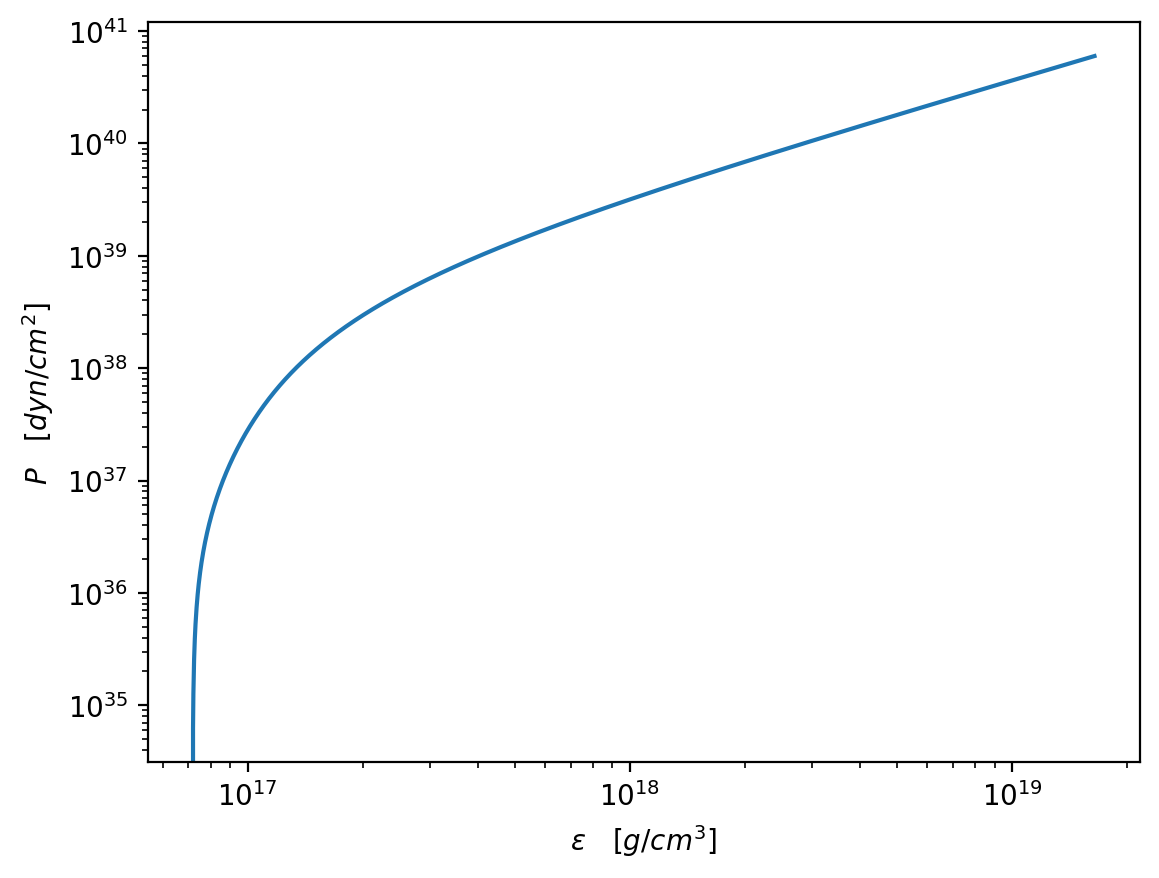

In [10]:
plt.figure(dpi=200)
plt.plot(energy_densities / g_cm_3, pressures / dyn_cm_2)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\epsilon\quad [g/cm^3]$")
plt.ylabel(r"$P\quad [dyn/cm^2]$")
plt.show()

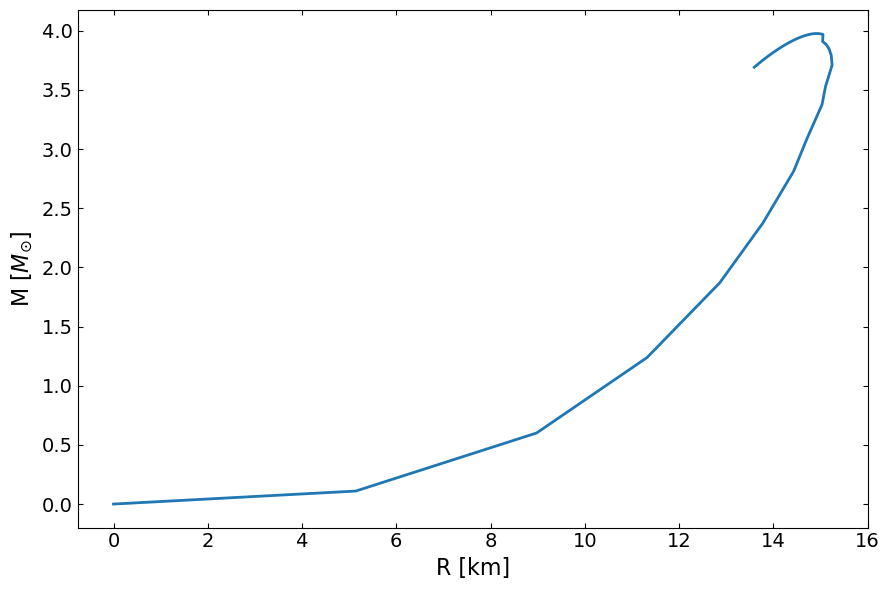

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.plot(MR[:,1]/km , MR[:,0]/Msun, lw=2)

ax.set_ylabel(r"M [$M_{\odot}$]", fontsize=16)
ax.set_xlabel("R [km]", fontsize=16)
# ax.set_xlim(8.0, 20.0)
# ax.set_ylim(0, 3)
ax.tick_params(top=1, right=1, which="both", direction="in", labelsize=14)
ax.tick_params(top=1, right=1, which="both", direction="in", labelsize=14)
fig.tight_layout()
plt.show()

## Speed of sound EOS 

First import all the package that will be used.

In [1]:
import numpy as np
import TOVsolver.main as main
import matplotlib.pyplot as plt
from EOSgenerators import SpeedofSound_EOS
import EOSgenerators.crust_EOS as crust
from TOVsolver.unit import g_cm_3, dyn_cm_2, km, Msun

The Speed of sound EOS describes the core EOS of a compact star, 
so it should be connected with the crust EOS to form a full EOS.
See https://arxiv.org/abs/1812.08188 for details.

In [2]:
Tolos_crust_out = np.loadtxt("Test_Case/Tolos_crust_out.txt")
eps_crust_T_out = Tolos_crust_out[:, 3] * g_cm_3
pres_crust_T_out = Tolos_crust_out[:, 4] * dyn_cm_2
eps_com, pres_com = crust.PolyInterpolate(eps_crust_T_out, pres_crust_T_out)

### (a) Defining the EOS parameters

To construct the Speed of sound EOS, we need to specify the outer crust EOS and 
the interface EOS, and then connect them with the core EOS.

In [43]:
x_last = eps_com[-1]
y_last = pres_com[-1]
dydx_last = (pres_com[-1] - pres_com[-2]) / (eps_com[-1] - eps_com[-2])
CS_EOS = SpeedofSound_EOS.compute_EOS(x_last, y_last, dydx_last)

In order to generate the parameters of the Speed of sound EOS, we need a list
of 5 uniform random numbers between 0 and 1.

After generate the parameters, we use function `check_a` to check if the parameters
are valid.

In [44]:
cs_a = CS_EOS.gen_a((0.2, 0.2, 0.3, 0.4, 0.5))
print(CS_EOS.check_a(cs_a))

True


### (b) Solve TOV with this EOS

Here below we use the speed of sound EOS to compute the mass radius curve.

First we calculate the core EOS.

In [45]:
core_e_min = x_last
core_e_max = 2e16 * g_cm_3
n_core_e = 1000
core_e = np.geomspace(core_e_min, core_e_max, n_core_e)
core_p = CS_EOS.cal_core_p(core_e, cs_a)

Then we concat the core EOS with the crust EOS.

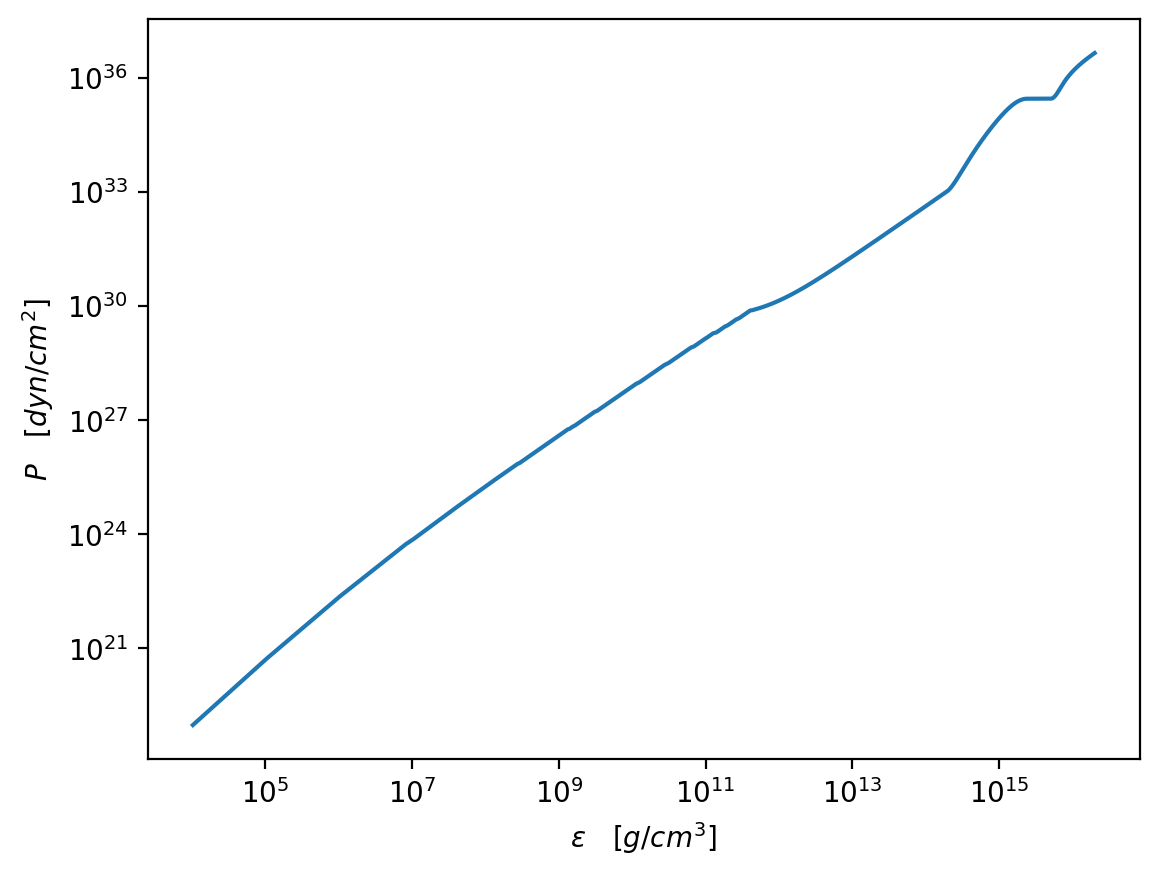

In [48]:
full_e = np.concatenate((eps_com, core_e[1:]))
full_p = np.concatenate((pres_com, core_p[1:]))
plt.figure(dpi=200)
plt.plot(full_e / g_cm_3, full_p / dyn_cm_2)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\epsilon\quad [g/cm^3]$")
plt.ylabel(r"$P\quad [dyn/cm^2]$")
plt.show()

Finally we compute the mass radius curve.

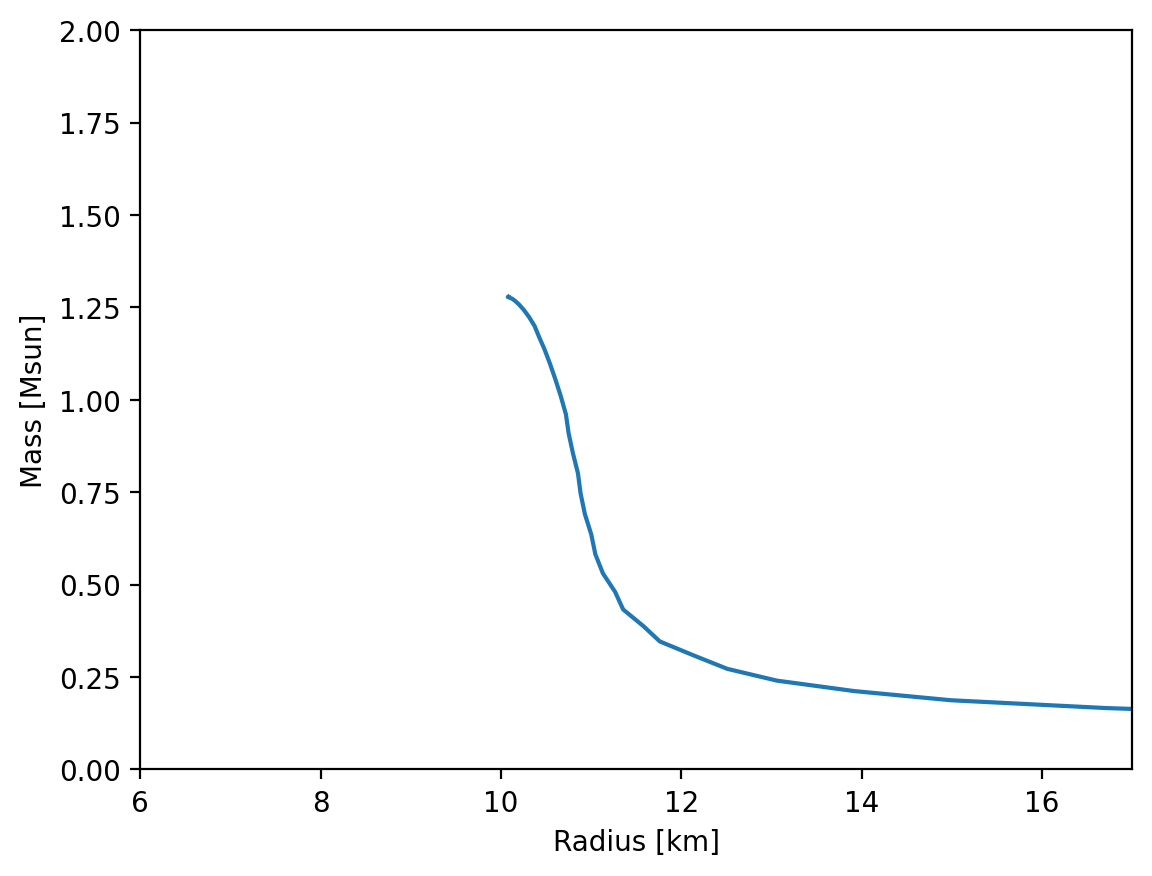

In [ ]:
MR = main.OutputMR("", full_e, full_p)
plt.figure(dpi=200)
plt.plot(MR[:, 1] / km, MR[:, 0] / Msun)
plt.xlim(6, 17)
plt.ylim(0, 2)
plt.xlabel("Radius [km]")
plt.ylabel("Mass [Msun]")
plt.show()

## MIT bag model EOS

The MIT bag model, which has commonly been applied to strange quark stars, relates pressure to energy density with the simple equation of state $p=\frac{\epsilon}{3}-\frac{4B}{3}$. There is only one parameter, the "bag constant" $B$. This represents the vacuum energy density, which creates a "bag" in which quarks are confined. See [Chodos et al. (1974)](https://doi.org/10.1103/PhysRevD.9.3471).

In [12]:
import numpy as np
from EOSgenerators import MITbag_EOS
from TOVsolver.unit import MeV, fm, g_cm_3, dyn_cm_2, km, Msun

### (a) Defining the parameter

A "typical" value of 57 $MeVfm^{-3}$ for the bag constant is taken from [Alcock (1986)](http://dx.doi.org/10.1086/164679).

In [13]:
B = 57

epsilon,p = MITbag_EOS.MITbag_compute_EOS(B)

print('energy density range:',epsilon[0],'to',epsilon[-1])
print('pressure range:',p[0],'to',p[-1])

energy density range: 1.1554421785237932 to 2.888605446309483
pressure range: 0.0 to 0.5777210892618965


### (b) Computing the mass-radius relation

We can compute a mass-radius relation for this EOS by solving the TOV equation.

In [14]:
import matplotlib.pyplot as plt
import TOVsolver.main as main
import TOVsolver.EoS_import as EoS_import
from itertools import repeat

In [15]:
MR = main.OutputMR('',epsilon,p).T

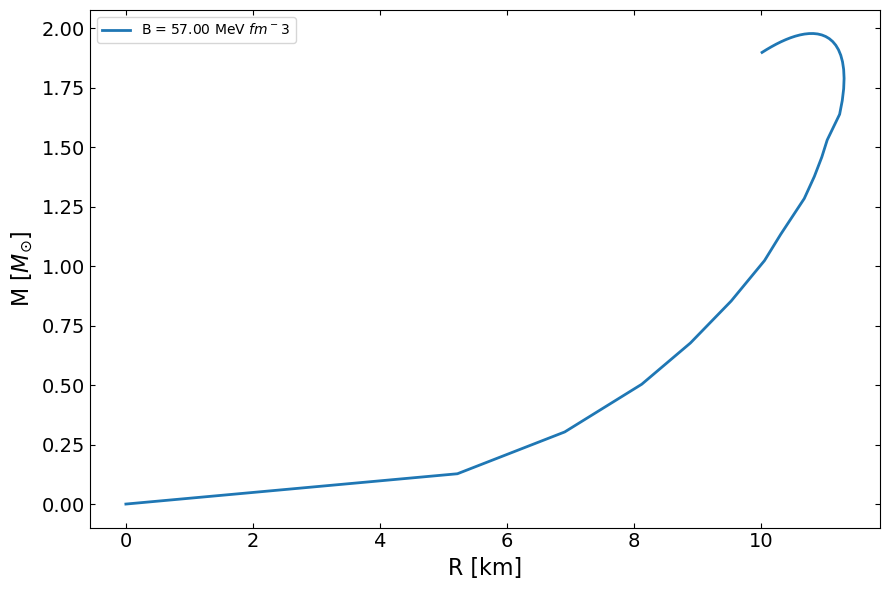

In [16]:
fig, ax = plt.subplots(1,1, figsize=(9,6))
ax.plot(MR[1]/km, MR[0]/Msun,lw=2,label=f'B = {B:.2f} MeV $fm^{-3}$')
ax.set_ylabel(r'M [$M_{\odot}$]', fontsize=16)
ax.set_xlabel('R [km]', fontsize=16)
ax.legend()
ax.tick_params(top=1,right=1, which='both', direction='in', labelsize=14)
ax.tick_params(top=1,right=1, which='both', direction='in', labelsize=14)
fig.tight_layout()
plt.show()